In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when

spark = SparkSession.builder \
    .appName("SECOP_RegresionLogistica") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

# Cargar datos
df = spark.read.parquet("/opt/spark-data/raw/secop_features.parquet")
print(f"Registros: {df.count():,}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/10 04:18:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Registros: 100,000


### **Crear variable objetivo binaria (definir criterio de riesgo)**

**Objetivo**: Crear columna "riesgo" con valores 0 (bajo) o 1 (alto)

**Ejemplos de criterios**:
 - Contratos grandes: valor > percentil 90
 - Contratos urgentes: plazo < 30 días
 - Departamentos históricos de incumplimiento
 - Combinación de factores

TODO: Calcula el percentil 90 del valor de contratos

Pista: df.approxQuantile("valor_del_contrato_num", [0.9], 0.01)


In [2]:
from pyspark.sql.functions import col, when, regexp_extract, ceil
df = df.withColumn(
    "duracion_dias",
    when(
        col("duraci_n_del_contrato").rlike("Hora"),
        ceil(regexp_extract(col("duraci_n_del_contrato"), r"(\d+)", 1).cast("double") / 24)
    ).when(
        col("duraci_n_del_contrato").rlike("Dia"),
        regexp_extract(col("duraci_n_del_contrato"), r"(\d+)", 1).cast("int")
    ).when(
        col("duraci_n_del_contrato").rlike("Mes"),
        regexp_extract(col("duraci_n_del_contrato"), r"(\d+)", 1).cast("int") * 30
    ).otherwise(None)
)

df = df.withColumn(
    "rango_duracion",
    when(col("duracion_dias").isNull(), "No definido")
    .when(col("duracion_dias") < 1, "< 1 día")
    .when(col("duracion_dias") < 7, "1-6 días")
    .when(col("duracion_dias") < 30, "7-29 días")
    .when(col("duracion_dias") < 90, "30-89 días")
    .when(col("duracion_dias") < 180, "90-179 días")
    .otherwise(">= 180 días")
)

print("\n=== DISTRIBUCIÓN POR RANGO DE DURACIÓN ===")
df.groupBy("rango_duracion").count().orderBy("count", ascending=False).show()



=== DISTRIBUCIÓN POR RANGO DE DURACIÓN ===


+--------------+-----+
|rango_duracion|count|
+--------------+-----+
|    30-89 días|60049|
|     7-29 días|18619|
|   >= 180 días|10819|
|   90-179 días| 6347|
|      1-6 días| 3237|
|   No definido|  909|
|       < 1 día|   20|
+--------------+-----+



26/02/10 04:19:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Percentil 90 del valor del contrato
p90 = df.approxQuantile(
    "valor_del_contrato_num",
    [0.9],
    0.01
)[0]

df = df.withColumn(
    "riesgo",
    when(
        # Regla 1: Riesgo financiero (aplica a TODOS)
        col("valor_del_contrato_num") >= p90,
        1
    ).when(
        # Regla 2: Riesgo operativo (solo si duración está definida)
        col("duracion_dias").isNotNull() & (col("duracion_dias") < 30),
        1
    ).otherwise(0)
)


### **Analizar balance de clases**

In [4]:
print("\n=== DISTRIBUCIÓN DE CLASES ===")
class_distribution = df.groupBy("riesgo").count()
class_distribution.show()

total = df.count()
clase_0 = df.filter(col("riesgo") == 0).count()
clase_1 = df.filter(col("riesgo") == 1).count()

print(f"0 = Bajo riesgo: {clase_0:,} ({clase_0/total*100:.1f}%)")
print(f"1 = Alto riesgo: {clase_1:,} ({clase_1/total*100:.1f}%)")



=== DISTRIBUCIÓN DE CLASES ===
+------+-----+
|riesgo|count|
+------+-----+
|     1|30717|
|     0|69283|
+------+-----+

0 = Bajo riesgo: 69,283 (69.3%)
1 = Alto riesgo: 30,717 (30.7%)


El dataset no está perfectamente balanceado, pero tampoco está severamente desbalanceado.

### **PASO 1: Preparar Datos**

In [5]:
# Renombrar columnas para el modelo
df_binary = df.withColumnRenamed("riesgo", "label") \
               .withColumnRenamed("features_raw", "features")

# Filtrar nulos
df_binary = df_binary.filter(
    col("label").isNotNull() & col("features").isNotNull())

# Split train/test
train, test = df_binary.randomSplit([0.7, 0.3], seed=42)

print(f"Train: {train.count():,}")
print(f"Test: {test.count():,}")

Train: 70,170
Test: 29,830


### **Entender la Regresión Logística**

**Pregunta conceptual**: ¿En qué se diferencia de regresión lineal?

**Opciones**:

 - A) Predice probabilidades entre 0 y 1
 - B) Usa función sigmoid
 - C) Es para clasificación, no para valores continuos
 - D) Todas las anteriores

Respuesta_Correcta: D

La regresión logística se diferencia de la regresión lineal en varios aspectos fundamentales. 
Mientras que la regresión lineal se utiliza para predecir valores continuos (por ejemplo, el valor
monetario de un contrato), la regresión logística está diseñada para problemas de clasificación 
donde el objetivo es estimar la probabilidad de pertenencia a una clase.

La regresión logística utiliza una función sigmoide que transforma la combinación lineal delas 
variables de entrada en un valor comprendido entre 0 y 1, el cual se interpreta como una probabildad. 
A partir de esta probabilidad, el modelo asigna una clase utilizando un threshold de de


### Configurar el Modelo

**Parámetros clave**:

 - maxIter: Iteraciones de optimización
 - regParam: Regularización (prevenir overfitting)
 - threshold: ¿A partir de qué probabilidad clasificar como 1?
 - family: "binomial" (predeterminado para clasificación binaria)
   cisión.turaleza del problema.


In [9]:
# TODO: Configura el modelo
lr_classifier = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.0,  # TODO: ¿Deberías usar regularización?
    threshold=0.5  # TODO: ¿Es apropiado si las clases están desbalanceadas?
)

print("✓ Clasificador configurado")

✓ Clasificador configurado


### **Responde:**

Si tienes 90% clase 0 y 10% clase 1, ¿que threshold usarias?

**Respuesta:**

Si el dataset presenta un desbalance fuerte, por ejemplo 90% clase 0 y 10% clase 1, utilizaria un threshold menor a 0.5 (por ejemplo 0.3). Esto permitiria aumentar la sensibilidad del modelo (Recall) para detectar mas casos de la clase minoritaria. Aun a costa de incrementar los falsos positivos.

### **Entrenamiento del modelo**os.

In [10]:
print("\nEntrenando clasificador...")
lr_model = lr_classifier.fit(train)
print("✓ Modelo entrenado")


Entrenando clasificador...
✓ Modelo entrenado


### **Predicciones**

In [11]:
predictions = lr_model.transform(test)

print("\n=== PRIMERAS PREDICCIONES ===")
predictions.select("label", "prediction", "probability").show(10, truncate=False)



=== PRIMERAS PREDICCIONES ===
+-----+----------+-------------------------------------------+
|label|prediction|probability                                |
+-----+----------+-------------------------------------------+
|1    |0.0       |[0.8958820786027868,0.10411792139721321]   |
|0    |0.0       |[0.8046917309156758,0.1953082690843242]    |
|0    |0.0       |[0.9230330748031699,0.07696692519683013]   |
|0    |0.0       |[0.9165657359355489,0.08343426406445109]   |
|1    |0.0       |[0.9184640697537452,0.08153593024625483]   |
|0    |0.0       |[0.8047515780466176,0.19524842195338243]   |
|1    |1.0       |[0.0013787547878183174,0.9986212452121817] |
|1    |1.0       |[1.8386425184674996E-30,1.0]               |
|1    |1.0       |[1.0521249088950033E-13,0.9999999999998948]|
|1    |1.0       |[2.282187807847956E-4,0.9997717812192152]  |
+-----+----------+-------------------------------------------+
only showing top 10 rows



### **Interpretar Probabilidades de Predicción**

En la regresión logística, la columna `probability` representa la probabilidad estimada de pertenecer a
cada una de las clases. En Spark ML, este vector se interpreta como:

- `probability[0]`: probabilidad de pertenecer a la clase 0 (bajo riesgo)
- `probability[1]`: probabilidad de pertenecer a la clase 1 (alto riesgo)

Por lo tanto, si se observa un valor `probability = [0.8, 0.2]`, esto significa que el model  estima
un **80% de probabilidad de que el contrato sea de bajo riesgo** y un **20% de probabilidad d  que sea
de alto riesgo**. En consecuencia, dado un threshold de 0.5, el modelo clasificaría este con rato como
bajo riesgo (clase 0).

Al analizar las predicciones generadas, se identifican casos donde la probabilidad de a to riesgo se
encuentra cercana al threshold de decisión (por ejemplo, entre 0.4 y 0.6). Estos casos  orresponden a
predicciones en las que el modelo iresenta mayor incertidumbre, ya que pequeñas va iaciones en el
threshold podrían cambiar la clase asignada.

La existencia de este tipo de observaciones resalta la importancia de no depende  únicamente de la
predicción binaria final, sino de analizar las probabilidades estimadas, especialme te en problemas de
clasificación de riesgo, donde los falsos negativos pueden tener consecuencias significativas.


### **Evaluar con AUC-ROC, Precision, Recall, F1**

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# AUC - ROC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator_auc.evaluate(predictions)

# Métricas multiclase
evaluator_multi = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction")

accuracy = evaluator_multi.evaluate(
    predictions,
    {evaluator_multi.metricName: "accuracy"})

precision = evaluator_multi.evaluate(
    predictions,
    {evaluator_multi.metricName: "weightedPrecision"})

recall = evaluator_multi.evaluate(
    predictions,
    {evaluator_multi.metricName: "weightedRecall"}
)

f1 = evaluator_multi.evaluate(
    predictions,
    {evaluator_multi.metricName: "f1"}
)

# Resultados
print("\n" + "="*60)
print("MÉTRICAS DE CLASIFICACIÓN")
print("="*60)
print(f"AUC-ROC:   {auc:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)



MÉTRICAS DE CLASIFICACIÓN
AUC-ROC:   0.8138
Accuracy:  0.8183
Precision: 0.8222
Recall:    0.8183
F1-Score:  0.8031


### **Matriz de Confusión**

In [13]:
print("\n=== MATRIZ DE CONFUSIÓN ===")
confusion_matrix = predictions.groupBy("label", "prediction").count()
confusion_matrix.orderBy("label", "prediction").show()



=== MATRIZ DE CONFUSIÓN ===


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|19713|
|    0|       1.0|  867|
|    1|       0.0| 4554|
|    1|       1.0| 4696|
+-----+----------+-----+



### **Calculo manual de TP, TN, FP y FN**

In [13]:
TP = predictions.filter(
    (col("label") == 1) & (col("prediction") == 1)
).count()

TN = predictions.filter(
    (col("label") == 0) & (col("prediction") == 0)
).count()

FP = predictions.filter(
    (col("label") == 0) & (col("prediction") == 1)
).count()

FN = predictions.filter(
    (col("label") == 1) & (col("prediction") == 0)
).count()

print("\n=== VALORES DE LA MATRIZ DE CONFUSIÓN ===")
print(f"TP (True Positive):  {TP}")
print(f"TN (True Negative):  {TN}")
print(f"FP (False Positive): {FP}")
print(f"FN (False Negative): {FN}")

total_confusion = TP + TN + FP + FN
print(f"\nTotal de registros evaluados: {total_confusion:,}")



=== VALORES DE LA MATRIZ DE CONFUSIÓN ===
TP (True Positive):  4696
TN (True Negative):  19713
FP (False Positive): 867
FN (False Negative): 4554

Total de registros evaluados: 29,830


### **Experimentar con diferentes thresholds**

In [14]:
thresholds = [0.3, 0.5, 0.7]

print("\n=== COMPARACIÓN DE THRESHOLDS ===")

for t in thresholds:
    lr_temp = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=100,
        threshold=t
    )
    
    model_temp = lr_temp.fit(train)
    preds_temp = model_temp.transform(test)

    acc_temp = evaluator_multi.evaluate(
        preds_temp,
        {evaluator_multi.metricName: "accuracy"}
    )
    
    rec_temp = evaluator_multi.evaluate(
        preds_temp,
        {evaluator_multi.metricName: "weightedRecall"}
    )

print(f"Threshold={t}: Accuracy={acc_temp:.3f}, Recall={rec_temp:.3f}")


=== COMPARACIÓN DE THRESHOLDS ===
Threshold=0.7: Accuracy=0.806, Recall=0.806


### **Implementar curva ROC**

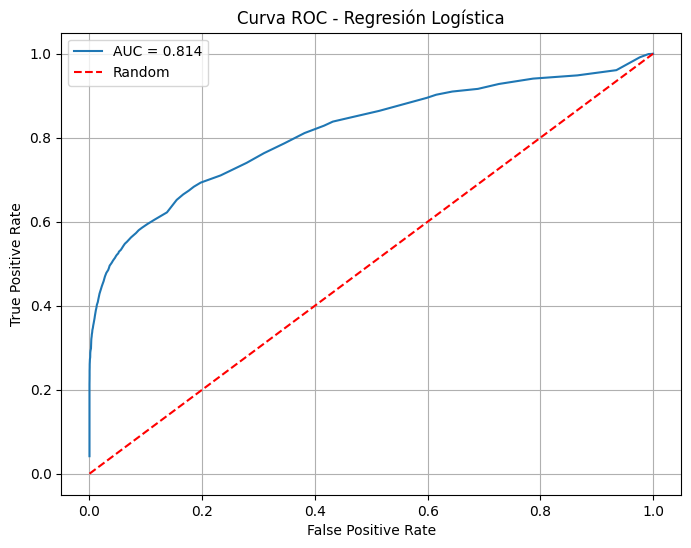

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer probabilidades del conjunto de test
prob_df = predictions.select("label", "probability").toPandas()

probs = np.array([p[1] for p in prob_df["probability"]])
labels = prob_df["label"].values

# Calcular TPR y FPR para distintos thresholds
thresholds_roc = np.linspace(0, 1, 100)

tpr_list = []
fpr_list = []

for t in thresholds_roc:
    y_pred = (probs >= t).astype(int)

    tp = np.sum((y_pred == 1) & (labels == 1))
    fp = np.sum((y_pred == 1) & (labels == 0))
    tn = np.sum((y_pred == 0) & (labels == 0))
    fn = np.sum((y_pred == 0) & (labels == 1))

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "r--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.grid(True)

In [16]:
# Guardar modelo
model_path = "/opt/spark-data/raw/logistic_regression_model"
lr_model.write().overwrite().save(model_path)
print(f"\n✓ Modelo guardado en: {model_path}")

# %%
print("RESUMEN CLASIFICACIÓN")
print("="*50)
print(f"✓ Criterio de riesgo definido")
print(f"✓ Modelo entrenado")
print(f"✓ AUC-ROC: {auc:.4f}")
print(f"✓ F1-Score: {f1:.4f}")
print("="*50)

# %%
spark.stop()


✓ Modelo guardado en: /opt/spark-data/raw/logistic_regression_model
RESUMEN CLASIFICACIÓN
✓ Criterio de riesgo definido
✓ Modelo entrenado
✓ AUC-ROC: 0.8138
✓ F1-Score: 0.8031
